# Mount drive and define path to TR project folder

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# change path to where text retrieval project is currently
%cd /content/drive/MyDrive/
#path = '/content/drive/MyDrive/583_TR_Project/'

Mounted at /content/drive
/content/drive/MyDrive


## Import libraries

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=206802069e511ee6b3e0867c2d85352cd36054a00286f303da323ff5eb17a68a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [6]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.4 MB/s eta 0:00:00


In [7]:
import warnings
import datasets
from collections import Counter, defaultdict
import numpy as np
import random
import pandas as pd
import ast
from itertools import groupby
from typing import List, Dict, Tuple, Union
import copy
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets
import math
import matplotlib.pyplot as plt
import copy
import torch
import code

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

warnings.filterwarnings("ignore")
datasets.logging.set_verbosity_error()
print("Datasets library version: ", datasets.__version__)

Datasets library version:  2.12.0


## Load tweets dataset

In [9]:
from datasets import load_dataset

dataset = load_dataset("tner/tweetner7")

Extracting data files:   0%|          | 0/11 [00:00<?, ?it/s]

Generating test_2020 split: 0 examples [00:00, ? examples/s]

Generating test_2021 split: 0 examples [00:00, ? examples/s]

Generating validation_2020 split: 0 examples [00:00, ? examples/s]

Generating validation_2021 split: 0 examples [00:00, ? examples/s]

Generating train_2020 split: 0 examples [00:00, ? examples/s]

Generating train_2021 split: 0 examples [00:00, ? examples/s]

Generating train_all split: 0 examples [00:00, ? examples/s]

Generating validation_random split: 0 examples [00:00, ? examples/s]

Generating train_random split: 0 examples [00:00, ? examples/s]

Generating extra_2020 split: 0 examples [00:00, ? examples/s]

Generating extra_2021 split: 0 examples [00:00, ? examples/s]

Dataset tweetner7 downloaded and prepared to /root/.cache/huggingface/datasets/tner___tweetner7/tweetner7/1.0.4/4b3d0bfbf7488c58c3d4f99bd75a25f0d6445951a6d335cb954431d5ac375751. Subsequent calls will reuse this data.


  0%|          | 0/11 [00:00<?, ?it/s]

## Inspect the dataset

In [10]:
dataset

DatasetDict({
    test_2020: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 576
    })
    test_2021: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 2807
    })
    validation_2020: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 576
    })
    validation_2021: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 310
    })
    train_2020: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 4616
    })
    train_2021: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 2495
    })
    train_all: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 7111
    })
    validation_random: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 576
    })
    train_random: Dataset({
        features: ['tokens', 'tags', 'id', 'date'],
        num_rows: 4616
    })
  

In [11]:
train = dataset["train_all"]
validation = dataset["validation_2021"]
test = dataset["test_2021"]

In [12]:
# print a single train example
print(train[0]['tokens'])
print(train[0]['tags'])
print(train[0]['id'])
print(train[0]['date'])

['Morning', '5km', 'run', 'with', '{{USERNAME}}', 'for', 'breast', 'cancer', 'awareness', '#', 'pinkoctober', '#', 'breastcancerawareness', '#', 'zalorafit', '#', 'zalorafitxbnwrc', '@', 'The', 'Central', 'Park', ',', 'Desa', 'Parkcity', '{{URL}}']
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 2, 14, 2, 14, 14, 14, 14, 14, 14, 4, 11, 11, 11, 11, 14]
1183344337016381440
2019-10-13


## Make NER labels of TweetNER compatible with CoNLL

In [13]:
tweetner_label2id = {
    "B-corporation": 0,
    "B-creative_work": 1,
    "B-event": 2,
    "B-group": 3,
    "B-location": 4,
    "B-person": 5,
    "B-product": 6,
    "I-corporation": 7,
    "I-creative_work": 8,
    "I-event": 9,
    "I-group": 10,
    "I-location": 11,
    "I-person": 12,
    "I-product": 13,
    "O": 14
}

tweetner_id2label = {i: label for label, i in tweetner_label2id.items()}

conll_label_list = ['O', 'PER', 'ORG', 'LOC', 'MISC']
conll_id2label = {'0': 'O', '1': 'PER', '2': 'ORG', '3': 'LOC', '4': 'MISC'}
conll_label2id = {'O': '0', 'PER': '1', 'ORG': '2', 'LOC': '3', 'MISC': '4'}

## Cleanup tweets

In [14]:
# also throws away tags key completely. int ner_tags will later be re-generated
def preprocess_tweets(example):

    # get tokens and ner_tags from example
    tokens = example['tokens']
    ner_tags = example['tags']
    # Find indices of items inside `{{ }}`
    brace_indices = [i for i, t in enumerate(tokens) if '{{' in t and '}}' in t]
    brace_indices += [brace_indices[-1]+1] if brace_indices and brace_indices[-1] != len(tokens)-1 else []
    
    # Find indices of '#' and '@' symbols
    hash_indices = [i for i, t in enumerate(tokens) if '#' in t]
    at_indices = [i for i, t in enumerate(tokens) if '@' in t]
    
    # add indices of the token immediately succeeding '#' to also be removed
    hash_indices_updated = []
    for hash_idx in hash_indices:
      hash_indices_updated.append(hash_idx)
      hash_indices_updated.append(hash_idx+1)

    # Combine all indices to be removed
    indices_to_remove = brace_indices + hash_indices_updated + at_indices
    
    # Remove items at the identified indices in tokens and ner_tags
    tokens = [t for i, t in enumerate(tokens) if i not in indices_to_remove]
    ner_tags = [n for j, n in enumerate(ner_tags) if j not in indices_to_remove]
    
    # update example dict - remove the old tags key and add truncated ner_tags key
    _ = example.pop('tags')
    example['tokens'] = tokens
    example['ner_tags'] = ner_tags
    return example



### Demonstrating how to clean up a single tweet example

In [15]:
# testing preprocessing on single dummy example
'''
example_1 = {
    'tokens': ['Morning', '5km', 'run', 'with', '{{USERNAME}}', 'for', 'breast', 'cancer', 'awareness', '#', 'pinkoctober', '#', 'breastcancerawareness', '#', 'zalorafit', '#', 'zalorafitxbnwrc', '@', 'The', 'Central', 'Park', ',', 'Desa', 'Parkcity', '{{URL}}'],
    'tags': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 2, 14, 2, 14, 14, 14, 14, 14, 14, 4, 11, 11, 11, 11, 14],
    'id': '1183344337016381440',
    'date': '2019-10-13'
}
clean_example_1 = preprocess_tweets(example_1)
print(clean_example_1)
assert len(clean_example_1['tokens']) == len(clean_example_1['ner_tags'])
'''

"\nexample_1 = {\n    'tokens': ['Morning', '5km', 'run', 'with', '{{USERNAME}}', 'for', 'breast', 'cancer', 'awareness', '#', 'pinkoctober', '#', 'breastcancerawareness', '#', 'zalorafit', '#', 'zalorafitxbnwrc', '@', 'The', 'Central', 'Park', ',', 'Desa', 'Parkcity', '{{URL}}'],\n    'tags': [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 2, 14, 2, 14, 14, 14, 14, 14, 14, 4, 11, 11, 11, 11, 14],\n    'id': '1183344337016381440',\n    'date': '2019-10-13'\n}\nclean_example_1 = preprocess_tweets(example_1)\nprint(clean_example_1)\nassert len(clean_example_1['tokens']) == len(clean_example_1['ner_tags'])\n"

In [16]:
# just adds string NER tags
def add_ner_tags_str(data, isTrain=True):
  new_data = []
  for i in range(len(data)):
    # if training data, only then preprocess tweets, otherwise don't
    if isTrain:
      data_i = preprocess_tweets(data[i])
      new_data_example = {}
      tokens = data_i['tokens']
      ner_tags = data_i['ner_tags']
      ner_tags_str = [tweetner_id2label[ner_tag] for ner_tag in data_i['ner_tags']]
      new_data_example['tokens'] = tokens
      new_data_example['ner_tags'] = ner_tags
      new_data_example['ner_tags_str'] = ner_tags_str
      new_data.append(new_data_example)
    # this is the preprocessing that gets applied on validation and test
    else:
      data_i = data[i]
      new_data_example = {}
      tokens = data_i['tokens']
      ner_tags = data_i['tags']
      ner_tags_str = [tweetner_id2label[ner_tag] for ner_tag in data_i['tags']]
      new_data_example['tokens'] = tokens
      new_data_example['ner_tags'] = ner_tags
      new_data_example['ner_tags_str'] = ner_tags_str
      new_data.append(new_data_example)

  new_data = datasets.Dataset.from_pandas(pd.DataFrame(data=new_data))
  return new_data
  
train = add_ner_tags_str(train)
validation = add_ner_tags_str(validation, False)
test = add_ner_tags_str(test, False)

In [17]:
# print a single train example after adding ner_tags_str
print("A single training example:")
print(train[0]['tokens'])
print(train[0]['ner_tags'])
print(train[0]['ner_tags_str'])

# print a single validation example after adding ner_tags_str
print("\nA single validation example:")
print(validation[0]['tokens'])
print(validation[0]['ner_tags'])
print(validation[0]['ner_tags_str'])

A single training example:
['Morning', '5km', 'run', 'with', 'for', 'breast', 'cancer', 'awareness', 'The', 'Central', 'Park', ',', 'Desa', 'Parkcity']
[14, 14, 14, 14, 14, 14, 14, 14, 14, 4, 11, 11, 11, 11]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'I-location', 'I-location', 'I-location', 'I-location']

A single validation example:
['Fear', 'the', 'Walking', 'Dead', 'Mid-Season', '6', 'Finale', 'Trailer', '{{URL}}', '#', 'FearTWD', '#', 'TWD', '#', 'TWDFamily', '#', 'AlyciaDebnamCarey', '#', 'TheWalkingDead', '{@Garret Dillahunt@}', '{@⚡️JENNA ELFMAN⚡️@}', '{@Alycia Debnam-Carey@}', '{@danaygarcia@}', '{@Colman Domingo@}', '#', 'fearthewalkingdead', '#', 'WalkingDead', '#', 'scifi', '#', 'horror', '#', 'GeekLove', '#', 'StaySafe']
[2, 9, 9, 9, 9, 9, 9, 9, 14, 14, 14, 14, 14, 14, 14, 14, 5, 14, 14, 5, 5, 5, 5, 5, 14, 1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
['B-event', 'I-event', 'I-event', 'I-event', 'I-event', 'I-event', 'I-event', 'I-event', 'O', 'O', 'O', 'O', 

In [18]:
type(train)

datasets.arrow_dataset.Dataset

In [19]:
# TODO: FLIP labels to CoNLL label space
def genConLL_labels(data):
  new_data = []
  for i in range(len(data)):
    data_i = data[i]
    new_data_example = {}
    tokens = data_i['tokens']
    ner_tags = data_i['ner_tags']
    ner_tags_str = data_i['ner_tags_str']

    for j in range(len(ner_tags_str)):
      if ner_tags_str[j] in ["B-corporation"]:
        ner_tags_str[j] = 'ORG'
      elif ner_tags_str[j] in ["B-location"]:
        ner_tags_str[j] = 'LOC'
      elif ner_tags_str[j] in ["B-person"]:
        ner_tags_str[j] = 'PER'
      elif ner_tags_str[j] in ["B-creative_work", "B-event", "B-product", "B-group"]:
        ner_tags_str[j] = 'MISC'
      elif ner_tags_str[j] in ["I-corporation"]:
        ner_tags_str[j] = 'ORG'
      elif ner_tags_str[j] in ["I-location"]:
        ner_tags_str[j] = 'LOC'
      elif ner_tags_str[j] in ["I-person"]:
        ner_tags_str[j] = 'PER'
      elif ner_tags_str[j] in ["I-creative_work", "I-event", "I-product", "I-group"]:
        ner_tags_str[j] = 'MISC'
      
    new_data_example['tokens'] = tokens
    new_data_example['ner_tags'] = [int(conll_label2id[ner_tag_str]) for ner_tag_str in ner_tags_str]
    new_data_example['ner_tags_str'] = ner_tags_str
    new_data.append(new_data_example)
  
  new_data = datasets.Dataset.from_pandas(pd.DataFrame(data=new_data))
  return new_data

In [20]:
train = genConLL_labels(train)
validation = genConLL_labels(validation)
test = genConLL_labels(test)

In [21]:
len(validation[0]['tokens']) == len(validation[0]['ner_tags'])

True

## Pretrained Model settings & dataloaders

In [22]:
from transformers import AutoTokenizer
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = 'SSL_classifier'#'microsoft/deberta-v3-base' 
BATCH_SIZE = 16
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

label_all_tokens = False

def tokenize_and_align_labels(examples):
    #print("Examples: {}\n".format(examples))
    #tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=256)
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=512)
    #print("Tokenized inputs: {}\n".format(tokenized_inputs))
    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        #print("i: {} and label: {}\n".format(i, label))
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        #print("word ids: {}\n".format(word_ids))
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                #if word_idx is not None and word_idx >= len(label):
                #  word_idx = len(label) - 1
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
              #if word_idx is not None and word_idx >= len(label):
              #  word_idx = len(label) - 1               
              label_ids.append(label[word_idx] if label_all_tokens else -100)
            
            previous_word_idx = word_idx
            #print("current label ids: {}\n".format(label_ids))

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(train[2:3])))
print(tokenize_and_align_labels(train[0:1]))

Final result after token-label alignment: {'input_ids': [[1, 307, 273, 382, 415, 331, 267, 818, 4125, 270, 1600, 388, 323, 273, 382, 415, 518, 757, 291, 267, 291, 707, 263, 273, 875, 264, 518, 398, 278, 541, 307, 341, 8696, 2318, 5854, 4658, 32888, 40306, 5933, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, -100, 4, -100]]}

{'input_ids': [[1, 8624, 456, 6275, 684, 275, 270, 4311, 1771, 3250, 279, 2332, 1269, 366, 10040, 452, 1269, 11563, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0,

In [23]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
data_collator = DataCollatorForTokenClassification(tokenizer)

In [24]:
validation.column_names

['tokens', 'ner_tags', 'ner_tags_str']

In [25]:
tokenized_train = train.map(tokenize_and_align_labels, batched=True, remove_columns=train.column_names, load_from_cache_file=False)
tokenized_validation = validation.map(tokenize_and_align_labels, batched=True, remove_columns=validation.column_names, load_from_cache_file=False)
tokenized_test = test.map(tokenize_and_align_labels, batched=True, remove_columns=test.column_names, load_from_cache_file=False)

Map:   0%|          | 0/7111 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Map:   0%|          | 0/2807 [00:00<?, ? examples/s]

In [26]:
train_dataloader = DataLoader(tokenized_train, collate_fn=data_collator, batch_size=1)
validation_dataloader = DataLoader(tokenized_validation, collate_fn=data_collator, batch_size=1)
test_dataloader = DataLoader(tokenized_test, collate_fn=data_collator, batch_size=1)

In [27]:
CoNLL_label_list = ['O', 'PER', 'ORG', 'LOC', 'MISC']

In [28]:
model_name = model_checkpoint

In [29]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, id2label=conll_id2label, label2id=conll_label2id)

args = TrainingArguments(
    f"{model_name}-finetuned-tweets-ner",
    learning_rate=1e-5,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=12,
    logging_steps=100,
    push_to_hub=False,
)
device = torch.device("cuda") 
print(device)
model = model.to(device)
print(next(model.parameters()).is_cuda) # returns a boolean

cuda
True


In [30]:
import pprint
import subprocess
import os

def evaluate_on_val(model, eval_dataloader):
  model.eval()
  global_val_labels= []
  global_val_predictions = []

  global_val_tokens = []

  for i, batch in enumerate(eval_dataloader):
    #print(batch)
    batch = tuple(batch[t].to(device) for t in batch)
    b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    #b_input_ids, b_input_mask, b_labels = batch
    orig_tokens = validation[i]["tokens"]
    #print(orig_tokens)
    
    for orig_token in orig_tokens:
      global_val_tokens.append(orig_token)
    
    # append '\n' to indicate end of this sentence
    global_val_tokens.append('\n')
    
    # check for empty example_dict['tokens'] = modified_ref_candidate_tokenstensor
    # if b_input_ids.nelement() == 0 or b_labels.nelement() == 0:
    #  print("Empty token list or label list found at index: {}, skipping....".format(i))
    #  continue
    
    # print("For i = {}, tokens = {}, ner_tags_str = {}, tokenized_labels = {}".format(i, validation[i]['tokens'], validation[i]['ner_tags_str'], b_labels))
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    predictions = outputs.logits.argmax(dim=-1)
    true_labels = [[CoNLL_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]
    true_predictions = [[CoNLL_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]

  
    # prepend B- prefix for true_predictions here
    for i in range(len(true_predictions)):
      for j in range(len(true_predictions[i])):
        if true_predictions[i][j] != 'O':
          true_predictions[i][j] = 'B-' + true_predictions[i][j]

    # prepend B- prefix for true_labels here 
    for i in range(len(true_labels)):
      for j in range(len(true_labels[i])):
        if true_labels[i][j] != 'O':
          true_labels[i][j] = 'B-' + true_labels[i][j]
  

    tp = true_predictions[0] + ['\n']
    tl = true_labels[0]  + ['\n']

    global_val_predictions.append(tp)
    global_val_labels.append(tl)

  # unroll global_val_predictions
  unrolled_global_val_predictions = [prediction for global_val_prediction in global_val_predictions for prediction in global_val_prediction]
  unrolled_global_val_labels = [label for global_val_label in global_val_labels for label in global_val_label] 

  # delete file if already exists
  if os.path.exists("output_val.txt"):
    os.remove("output_val.txt")

  # create output.txt file for conll-style evaluation
  file = open('output_val.txt','w')
  for token, label, prediction in zip(global_val_tokens, unrolled_global_val_labels, unrolled_global_val_predictions):
    if token != '\n':
      file.writelines(token + ' ' + label + ' ' + prediction + '\n')
    else:
      file.writelines(token)
  
  file.close()

  process = subprocess.run(['python', 'habitus/conlleval.py', 'output_val.txt'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
  pprint.pprint(process.stdout.strip())


In [31]:
#evaluate_on_val(model, validation_dataloader) # doesn't work for emoji's and hashtags and stuff

### try an alternate evaluation (later)

In [32]:
import pprint
import subprocess
import os
import evaluate
metric = evaluate.load("seqeval")

def compute_metrics_validation(model, eval_dataloader):
  model.eval()
  global_val_labels= []
  global_val_predictions = []

  global_val_tokens = []

  for i, batch in enumerate(eval_dataloader):
    #print(batch)
    batch = tuple(batch[t].to(device) for t in batch)
    b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    #b_input_ids, b_input_mask, b_labels = batch
    orig_tokens = validation[i]["tokens"]
    #print(orig_tokens)
    
    for orig_token in orig_tokens:
      global_val_tokens.append(orig_token)
    
    # append '\n' to indicate end of this sentence
    global_val_tokens.append('\n')
    
    # check for empty example_dict['tokens'] = modified_ref_candidate_tokenstensor
    # if b_input_ids.nelement() == 0 or b_labels.nelement() == 0:
    #  print("Empty token list or label list found at index: {}, skipping....".format(i))
    #  continue
    
    # print("For i = {}, tokens = {}, ner_tags_str = {}, tokenized_labels = {}".format(i, validation[i]['tokens'], validation[i]['ner_tags_str'], b_labels))
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    predictions = outputs.logits.argmax(dim=-1)
    true_labels = [[CoNLL_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]
    true_predictions = [[CoNLL_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]

  
    # prepend B- prefix for true_predictions here
    for i in range(len(true_predictions)):
      for j in range(len(true_predictions[i])):
        if true_predictions[i][j] != 'O':
          true_predictions[i][j] = 'B-' + true_predictions[i][j]

    # prepend B- prefix for true_labels here 
    for i in range(len(true_labels)):
      for j in range(len(true_labels[i])):
        if true_labels[i][j] != 'O':
          true_labels[i][j] = 'B-' + true_labels[i][j]
  

    tp = true_predictions[0] + ['\n']
    tl = true_labels[0]  + ['\n']

    global_val_predictions.append(tp)
    global_val_labels.append(tl)
  
  all_metrics = metric.compute(predictions=global_val_predictions, references=global_val_labels)
  return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
        }

  


In [33]:
compute_metrics_validation(model, validation_dataloader)

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'precision': 0.2913306451612903,
 'recall': 0.1956668923493568,
 'f1': 0.2341028756581612,
 'accuracy': 0.8586115734847743}

In [34]:
trainer = Trainer(model, args, train_dataset=tokenized_train, data_collator=data_collator, tokenizer=tokenizer)
# We finetune SSL further
train = trainer.train()

Step,Training Loss
100,0.311700
200,0.252000
300,0.248800
400,0.233600
500,0.220500
600,0.208400
700,0.219900
800,0.212400
900,0.209600
1000,0.197400


In [35]:
# after training, evaluate on dev
# evaluate_on_val(model, validation_dataloader)

# if the above doesn't work, do this
compute_metrics_validation(model, validation_dataloader)

{'precision': 0.6114890400604687,
 'recall': 0.5477318889641164,
 'f1': 0.5778571428571427,
 'accuracy': 0.897091941643004}

In [36]:
def evaluate_on_test(model, test_dataloader):
  model.eval()
  global_val_labels= []
  global_val_predictions = []

  global_val_tokens = []

  for i, batch in enumerate(test_dataloader):
    batch = tuple(batch[t].to(device) for t in batch)
    b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    orig_tokens = test[i]["tokens"]
    #print(orig_tokens)
    
    for orig_token in orig_tokens:
      global_val_tokens.append(orig_token)
    
    # append '\n' to indicate end of this sentence
    global_val_tokens.append('\n')
    
    # check for empty tensor
    if b_input_ids.nelement() == 0 or b_labels.nelement() == 0:
      print("Empty token list or label list found at index: {}, skipping....".format(i))
      continue
    
    # print("For i = {}, tokens = {}, ner_tags_str = {}, tokenized_labels = {}".format(i, validation[i]['tokens'], validation[i]['ner_tags_str'], b_labels))
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    predictions = outputs.logits.argmax(dim=-1)
    true_labels = [[CoNLL_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]
    true_predictions = [[CoNLL_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]

  
    # prepend B- prefix for true_predictions here
    for i in range(len(true_predictions)):
      for j in range(len(true_predictions[i])):
        if true_predictions[i][j] != 'O':
          true_predictions[i][j] = 'B-' + true_predictions[i][j]

    # prepend B- prefix for true_labels here 
    for i in range(len(true_labels)):
      for j in range(len(true_labels[i])):
        if true_labels[i][j] != 'O':
          true_labels[i][j] = 'B-' + true_labels[i][j]
  

    tp = true_predictions[0] + ['\n']
    tl = true_labels[0]  + ['\n']

    global_val_predictions.append(tp)
    global_val_labels.append(tl)

  # unroll global_val_predictions
  unrolled_global_val_predictions = [prediction for global_val_prediction in global_val_predictions for prediction in global_val_prediction]
  unrolled_global_val_labels = [label for global_val_label in global_val_labels for label in global_val_label] 

  # delete file if already exists
  if os.path.exists("output_val.txt"):
    os.remove("output_val.txt")

  # create output.txt file for conll-style evaluation
  file = open('output_val.txt','w')
  for token, label, prediction in zip(global_val_tokens, unrolled_global_val_labels, unrolled_global_val_predictions):
    if token != '\n':
      file.writelines(token + ' ' + label + ' ' + prediction + '\n')
      #print(token + ' ' + label + ' ' + prediction + '\n')
    else:
      #print(token)
      file.writelines(token)
  
  file.close()

  process = subprocess.run(['python', 'habitus/conlleval.py', 'output_val.txt'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
  pprint.pprint(process.stdout.strip())


In [37]:
#evaluate_on_test(model, test_dataloader) # doesn't work for emoji's, hashtags and stuff

In [38]:
def compute_metrics_test(model, test_dataloader):
  model.eval()
  global_val_labels= []
  global_val_predictions = []

  global_val_tokens = []

  for i, batch in enumerate(test_dataloader):
    batch = tuple(batch[t].to(device) for t in batch)
    b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
    orig_tokens = test[i]["tokens"]
    #print(orig_tokens)
    
    for orig_token in orig_tokens:
      global_val_tokens.append(orig_token)
    
    # append '\n' to indicate end of this sentence
    global_val_tokens.append('\n')
    
    # check for empty tensor
    if b_input_ids.nelement() == 0 or b_labels.nelement() == 0:
      print("Empty token list or label list found at index: {}, skipping....".format(i))
      continue
    
    # print("For i = {}, tokens = {}, ner_tags_str = {}, tokenized_labels = {}".format(i, validation[i]['tokens'], validation[i]['ner_tags_str'], b_labels))
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    predictions = outputs.logits.argmax(dim=-1)
    true_labels = [[CoNLL_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]
    true_predictions = [[CoNLL_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, b_labels)]

  
    # prepend B- prefix for true_predictions here
    for i in range(len(true_predictions)):
      for j in range(len(true_predictions[i])):
        if true_predictions[i][j] != 'O':
          true_predictions[i][j] = 'B-' + true_predictions[i][j]

    # prepend B- prefix for true_labels here 
    for i in range(len(true_labels)):
      for j in range(len(true_labels[i])):
        if true_labels[i][j] != 'O':
          true_labels[i][j] = 'B-' + true_labels[i][j]
  

    tp = true_predictions[0] + ['\n']
    tl = true_labels[0]  + ['\n']

    global_val_predictions.append(tp)
    global_val_labels.append(tl)

  all_metrics = metric.compute(predictions=global_val_predictions, references=global_val_labels)
  return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
        }

In [59]:
compute_metrics_test(model, test_dataloader)

{'precision': 0.5943582975915539,
 'recall': 0.5546063264834911,
 'f1': 0.5737946410797469,
 'accuracy': 0.8990589880088187}

In [55]:
trainer.save_model('SSL_Twitter_final')

## TF-IDF prototyping

In [ ]:
import math
import copy
import numpy as np

# Define the query and document as strings
query = "best car insurance"
document = "car insurance auto insurance"

# Tokenize the query and document into individual terms
query_tokens = query.split()
document_tokens = document.split()

print("Query tokens: {}\n".format(query_tokens))
print("Document tokens: {}\n".format(document_tokens))


# Log-weight the term frequency of each term in the query and document
query_tf = {term: 1+math.log10(query_tokens.count(term)) for term in query_tokens}
# Set the Log-weight of each term in document that doesn't appear in query to be 0
for term in document_tokens:
  if term not in query_tokens:
    query_tf[term] = 0

print("Query tf weights: {}\n".format(query_tf))

document_tf = {term: 1+math.log10(document_tokens.count(term)) for term in document_tokens}
# Set the Log-weight of each term in query that doesn't appear in document to be 0
for term in query_tokens:
  if term not in document_tokens:
    document_tf[term] = 0

print("Document tf weights: {}\n".format(document_tf))

# IDF weight each term in the query
N = 997631
# counts in how many documents each query term appears
query_df = {'auto': 5000, 'best': 50000, 'car': 10000, 'insurance': 1000}

#query_idf = {term: math.log10(N / (1 + document_tokens.count(term))) for term in query_tf}

query_idf = {term: math.log10(N / (1 + query_df[term])) for term in query_df}
print("Query IDF weights: {}\n".format(query_idf))

# Calculate the TF-IDF score for each term in the query and document
query_tfidf = {term: query_tf[term] * query_idf[term] for term in query_tf}
print("Query TFIDF weights: {}\n".format(query_tfidf))

query_vector = [query_tfidf[term] for term in query_tfidf]

document_weights = copy.deepcopy(document_tf)

print("Document weights: {}\n".format(document_weights))

document_vector = [document_weights[term] for term in query_tfidf]

print("Query vector: {}\n".format(query_vector))
print("Document vector: {}\n".format(document_vector))

# Perform cosine length normalization for the document
document_length = math.sqrt(sum([score ** 2 for score in document_vector]))
document_normalized = [score / document_length if document_length != 0 else 0 for score in document_vector]

print("document norm: {}\n".format(document_length))

print("document normalized scores: {}\n".format(document_normalized))

sim_score = np.dot(np.array(query_vector), np.array(document_normalized))

print("similarity score of document with query: {}\n".format(sim_score))

'''
N = 1  # number of documents (in this case, only one document)
query_idf = {term: 0 if query_tf[term] == 0 else math.log10(N / (1 + document_tokens.count(term))) for term in query_tf}

# Calculate the TF-IDF score for each term in the query and document
query_tfidf = {term: query_tf[term] * query_idf[term] for term in query_tf}
document_tfidf = {term: document_tf[term] * query_idf[term] for term in document_tf}

# Perform cosine length normalization for the document
document_vector = [document_tfidf[term] for term in query_tf]
document_length = math.sqrt(sum([score ** 2 for score in document_vector]))
document_normalized = [score / document_length if document_length != 0 else 0 for score in document_vector]

# Print the final TF-IDF score vectors for both query and document
print("Query TF-IDF score vector:", query_tfidf)
print("Document TF-IDF score vector:", document_normalized)
'''


Query tf weights: {'best': 1.0, 'car': 1.0, 'insurance': 1.0, 'auto': 0}

Document tf weights: {'car': 1.0, 'insurance': 1.3010299956639813, 'auto': 1.0, 'best': 0}

Query IDF weights: {'auto': 2.2999130812313218, 'best': 1.2999912456401903, 'car': 1.9989265085021266, 'insurance': 2.998535858299671}

Query TFIDF weights: {'best': 1.2999912456401903, 'car': 1.9989265085021266, 'insurance': 2.998535858299671, 'auto': 0.0}

Document weights: {'car': 1.0, 'insurance': 1.3010299956639813, 'auto': 1.0, 'best': 0}

Query vector: [1.2999912456401903, 1.9989265085021266, 2.998535858299671, 0.0]

Document vector: [0, 1.0, 1.3010299956639813, 1.0]

document norm: 1.9216344734671627

document normalized scores: [0.0, 0.5203903311516482, 0.6770434302818067, 0.5203903311516482]

similarity score of document with query: 3.0703610310334404



'\nN = 1  # number of documents (in this case, only one document)\nquery_idf = {term: 0 if query_tf[term] == 0 else math.log10(N / (1 + document_tokens.count(term))) for term in query_tf}\n\n# Calculate the TF-IDF score for each term in the query and document\nquery_tfidf = {term: query_tf[term] * query_idf[term] for term in query_tf}\ndocument_tfidf = {term: document_tf[term] * query_idf[term] for term in document_tf}\n\n# Perform cosine length normalization for the document\ndocument_vector = [document_tfidf[term] for term in query_tf]\ndocument_length = math.sqrt(sum([score ** 2 for score in document_vector]))\ndocument_normalized = [score / document_length if document_length != 0 else 0 for score in document_vector]\n\n# Print the final TF-IDF score vectors for both query and document\nprint("Query TF-IDF score vector:", query_tfidf)\nprint("Document TF-IDF score vector:", document_normalized)\n'

# Actual Jeopardy code

## Import SpaCY dependencies

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-04 17:17:42.054277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 17:17:43.914871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import re
import spacy
import os
import pickle

nlp = spacy.load('en_core_web_sm')

## Retrieve Answers from Jeopardy dataset questions file!

In [4]:
path_name = "questions.txt"

questions = []
answers = []

with open(path_name, "r", encoding="utf8") as f:
    # Initialize variables
    objects = []
    current_obj = {}

    # Loop over each line in the file
    for line in f:
        # Strip any whitespace and skip empty lines
        line = line.strip()
        if not line:
            continue

        # Check if this line is a category
        if not current_obj:
            current_obj["category"] = line
        else:
            # Add the question or answer to the current object
            if "question" not in current_obj:
                current_obj["question"] = line
                questions.append(line)
            else:
                current_obj["answer"] = line
                answers.append(line)
                # Add the current object to the list and reset it
                objects.append(current_obj)
                current_obj = {}

    # Add the last object to the list
    if current_obj:
        objects.append(current_obj)

'''
# Print the list of objects
for obj in objects:
    print(obj)

'''  

'\n# Print the list of objects\nfor obj in objects:\n    print(obj)\n\n'

In [5]:
# Define a regular expression pattern to match non-alphabetic characters
pattern = re.compile(r'[^a-zA-Z0-9 ]+')
questions_lemmatized = []
for question in questions:
  doc = nlp(question)
  lemmatized_tokens = ' '.join([token.lemma_ for token in doc])
  lemmatized_tokens = re.sub(pattern, ' ', lemmatized_tokens)
  lemmatized_tokens = ' '.join(lemmatized_tokens.split()).lower()
  questions_lemmatized.append(lemmatized_tokens)

print("Length of questions lemmatized: {}\n".format(len(questions_lemmatized)))

Length of questions lemmatized: 100



## Store a mapping from lemmatized questions to answers (may be 1 or more)

In [11]:
from collections import defaultdict
q_to_ans = defaultdict(list)

def answer_lemmatizer(answer):
  pattern = re.compile(r'[^a-zA-Z0-9 ]+')
  lemmatized_ans = re.sub(pattern, ' ', answer)
  lemmatized_ans = ' '.join(lemmatized_ans.split()).lower()
  return lemmatized_ans

for i in range(len(questions_lemmatized)):
  answer = answers[i]
  # if there is a '|' in answer, break it into sub answers and add them to the defaultdict
  if '|' in answer:
    sub_answer_tokens = answer.split('|')
    for token in sub_answer_tokens:
      q_to_ans[questions_lemmatized[i]].append(answer_lemmatizer(token))
  else:
      q_to_ans[questions_lemmatized[i]].append(answer_lemmatizer(answer))
    
print("Length of questions_lemmatized_to_answers: {}\n".format(len(q_to_ans)))

print("questions_lemmatized_to_answers dict: {}\n".format(q_to_ans))


answers_fixed = []
for answer in answers:
  if '|' in answer:
    sub_answer_tokens = answer.split('|')
    for token in sub_answer_tokens:
      answers_fixed.append(token)
  else:
    answers_fixed.append(answer)

print("Length of answers fixed: {}\n".format(len(answers_fixed)))


Length of questions_lemmatized_to_answers: 100

questions_lemmatized_to_answers dict: defaultdict(<class 'list'>, {'the dominant paper in our nation s capital it be among the top 10 u s paper in circulation': ['the washington post'], 'the practice of pre authorizing presidential use of force date to a 1955 resolution re this island near mainland china': ['taiwan'], 'daniel hertzberg james b stewart of this paper share a 1988 pulitzer for their story about insider trading': ['the wall street journal'], 'song that say you make i smile with my heart your look be laughable unphotographable': ['my funny valentine'], 'in 2011 bell ringer for this charity start accept digital donation to its red kettle': ['the salvation army', 'salvation army'], 'the naples museum of art': ['florida'], 'this italian painter depict the adoration of the golden calf': ['tintoretto'], 'this woman who win consecutive heptathlon at the olympics go to ucla on a basketball scholarship': ['jackie joyner kersee'], 'ori

In [7]:
print(questions_lemmatized[0:5])

['the dominant paper in our nation s capital it be among the top 10 u s paper in circulation', 'the practice of pre authorizing presidential use of force date to a 1955 resolution re this island near mainland china', 'daniel hertzberg james b stewart of this paper share a 1988 pulitzer for their story about insider trading', 'song that say you make i smile with my heart your look be laughable unphotographable', 'in 2011 bell ringer for this charity start accept digital donation to its red kettle']


In [12]:

pattern = re.compile(r'[^a-zA-Z0-9 ]+')
answers_lemmatized = []
for answer in answers_fixed:
  lemmatized_ans = re.sub(pattern, ' ', answer)
  lemmatized_ans = ' '.join(lemmatized_ans.split()).lower()
  #print(lemmatized_ans)
  answers_lemmatized.append(lemmatized_ans)

'''
  doc = nlp(answer)
  lemmatized_tokens = ' '.join([token.lemma_ for token in doc])
  lemmatized_tokens = re.sub(pattern, ' ', lemmatized_tokens)
  lemmatized_tokens = ' '.join(lemmatized_tokens.split()).lower()
  answers_lemmatized.append(lemmatized_tokens)
'''
print("Length of answers lemmatized: {}\n".format(len(answers_lemmatized)))

Length of answers lemmatized: 115



In [9]:
pickle_file_name = 'my_pickle_file.pkl'
# Open the pickle file in read mode
with open(pickle_file_name, 'rb') as f:
    # Load the serialized data from the file using pickle.load()
    jeopardy_data = pickle.load(f)
print("Length of read jeopardy data: {}\n".format(len(jeopardy_data)))

Length of read jeopardy data: 1838



In [ ]:
jeopardy_data[0]

In [14]:

sanity_cnt = 0
for answer in answers_lemmatized:
  found = False
  for i in range(len(jeopardy_data)):
    if jeopardy_data[i]['title'] == answer:
      #print(i, jeopardy_data[i]['title'])
      sanity_cnt += 1
      found = True
  if not found:
    print("{} was not found anywhere in jeopardy data dict\n".format(answer))

print("Titles found in jeopardy data dict: {}\n".format(sanity_cnt))



my funny valentine was not found anywhere in jeopardy data dict

salvation army was not found anywhere in jeopardy data dict

florida was not found anywhere in jeopardy data dict

rotary international was not found anywhere in jeopardy data dict

de gaulle was not found anywhere in jeopardy data dict

ohio was not found anywhere in jeopardy data dict

arlington national cemetery was not found anywhere in jeopardy data dict

arlington cemetery was not found anywhere in jeopardy data dict

iberia was not found anywhere in jeopardy data dict

iberian peninsula was not found anywhere in jeopardy data dict

panda was not found anywhere in jeopardy data dict

giant panda was not found anywhere in jeopardy data dict

george michael was not found anywhere in jeopardy data dict

the help was not found anywhere in jeopardy data dict

world wide fund was not found anywhere in jeopardy data dict

world wide fund for nature was not found anywhere in jeopardy data dict

komodo dragon was not found a

In [17]:
global_candidate_title_list = [] # allow cross search in other questions top-20 to find best ans/title

## Manual Implementation of TF-IDF using lnc.ltn weighting

In [69]:
import math
import copy
import numpy as np

def TFIDF(question, document, jeopardy_data):
  # Tokenize the query and document into individual terms
  query_tokens = question.split()
  document_tokens = document #.split() - already tokenized

  #print("Query tokens: {}\n".format(query_tokens))
  #print("Document tokens: {}\n".format(document_tokens))


  # Log-weight the term frequency of each term in the query and document
  query_tf = {term: 1+math.log10(query_tokens.count(term)) for term in query_tokens}
  # Set the Log-weight of each term in document that doesn't appear in query to be 0
  for term in document_tokens:
    if term not in query_tokens:
      query_tf[term] = 0

  #print("Query tf weights: {}\n".format(query_tf))

  document_tf = {term: 1+math.log10(document_tokens.count(term)) for term in document_tokens}
  # Set the Log-weight of each term in query that doesn't appear in document to be 0
  for term in query_tokens:
    if term not in document_tokens:
      document_tf[term] = 0

  #print("Document tf weights: {}\n".format(document_tf))

  assert len(query_tf.keys()) == len(document_tf.keys())
  # Statistics to compute IDF weight of each term in the query
  N = len(jeopardy_data)

  # counts in how many documents each query term appears
  query_df = {}
  for j in range(len(jeopardy_data)):
    page_title = jeopardy_data[i]['title'].split(' ')
    page_tokens = jeopardy_data[i]['tokens']
    # check if query term appears in the title OR tokens - increment its df by 1 only in either case
    for term in query_tf:
      if term in page_title or term in page_tokens:
        if term not in query_df:
          query_df[term] = 0
        else:
          query_df[term] += 1
      # if the term doesn't appear in any page title or page_token - still set its df to be 0
      if term not in query_df:
        query_df[term] = 0

  #print("Query DF: {}\n".format(query_df))

  #query_df = {'auto': 5000, 'best': 50000, 'car': 10000, 'insurance': 1000}

  #query_idf = {term: math.log10(N / (1 + document_tokens.count(term))) for term in query_tf}

  query_idf = {term: math.log10(N / (1 + query_df[term])) for term in query_df}
  #print("Query IDF weights: {}\n".format(query_idf))

  # Calculate the TF-IDF score for each term in the query and document
  query_tfidf = {term: query_tf[term] * query_idf[term] for term in query_tf}
  #print("Query TFIDF weights: {}\n".format(query_tfidf))

  query_vector = [query_tfidf[term] for term in query_tfidf]

  document_weights = copy.deepcopy(document_tf)

  #print("Document weights: {}\n".format(document_weights))

  document_vector = [document_weights[term] for term in query_tfidf]

  #print("Query vector: {}\n".format(query_vector))
  #print("Document vector: {}\n".format(document_vector))

  # Perform cosine length normalization for the document
  document_length = math.sqrt(sum([score ** 2 for score in document_vector]))
  document_normalized = [score / document_length if document_length != 0 else 0 for score in document_vector]

  #print("document norm: {}\n".format(document_length))

  #print("document normalized scores: {}\n".format(document_normalized))

  sim_score = np.dot(np.array(query_vector), np.array(document_normalized))

  #print("similarity score of document with query: {}\n".format(sim_score))

  return sim_score # similarity b/w single question and document

In [ ]:
# retrieve titles and page content of top-20 candidate's for each question
for i in range(2, len(questions_lemmatized)+1):
  #print(questions_lemmatized[i])

  # Set the question number
  question_number = "Q"+str(i)

  # Construct the file path
  file_path = os.path.join("questions", question_number, f"{question_number}_candidate_answers")

  # Open the file and read the lines into a list
  with open(file_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

  # Print the list of lines - which are candidate titles for that doc
  local_candidates = [] # list of tuples with title/answer and TFIDF score
  jeopardy_data_subset = []
  for cand_title in lines:
    # retrieve docs from jeopardy data
    for j in range(len(jeopardy_data)):
      if jeopardy_data[j]["title"] == cand_title:
        # if we only want to search in the top-20 candidates for each question
        jeopardy_data_subset.append(jeopardy_data[j])
    
  # operate over jeopardy data subset only - retrieve docs only from the subset
  '''
  for cand_doc in jeopardy_data_subset:
    # call TFIDF here
    cand_doc_score = TFIDF(questions_lemmatized[i], cand_doc['tokens'], jeopardy_data_subset)
    local_candidates.append((cand_doc['title'], cand_doc_score))
  '''
  # operate over full jeopardy dataset
  for cand_doc in jeopardy_data:
    # call TFIDF here
    cand_doc_score = TFIDF(questions_lemmatized[i], cand_doc['tokens'], jeopardy_data)
    local_candidates.append((cand_doc['title'], cand_doc_score))

  local_candidates_ranked = sorted(local_candidates, key=lambda x: x[1], reverse=True)
  print(local_candidates_ranked)

  # just check one for now
  break

## TF-IDF sklearn Implementation

In [70]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


class TFIDF:
    """
    This class helps in representing text to their numeric equivalent by spliting stream of text into tokens (words) and 
    using their normalize values (L2 in this case) to create the numberic matrics
    """
    def __init__(self,max_features=50000):

        super(TFIDF,self).__init__()
        self.max_features = max_features
        self.tfidf_vectorizor = TfidfVectorizer(decode_error='replace', strip_accents='unicode', analyzer='word',
                                                stop_words=None, ngram_range=(1, 1), max_features=self.max_features,
                                                norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

    def create_tfidf_features(self,corpus):
        """
        Creates a tf-idf matrix for the input corpus of data
        param corpus: input text/documents collection
        return: tfidf matrix
        """
        tfidf_mat = self.tfidf_vectorizor.fit_transform(corpus)
        print('tfidf matrix successfully created.')
        return tfidf_mat

    def calculate_similarity(self, tfidf_mat, text_str, top_k=10):
        """ 
        Vectorizes the text/document via `vectorizor` and calculates the cosine similarity of
        the text/document and tfidf_mat (all the documents) and returns the `top_k` similar documents
        """
        # Vectorize the query to the same length as documents
        text_vec = self.tfidf_vectorizor.transform(text_str)
        # Compute the cosine similarity between text_vec and all the texts/documents
        cosine_similarities = cosine_similarity(tfidf_mat, text_vec).flatten()
        # Sort the similar documents from the most similar to less similar and return the indices
        most_similar_doc_indices = np.argsort(cosine_similarities, axis=0)[:-top_k - 1:-1]
        return (most_similar_doc_indices, cosine_similarities)

    def show_similar_texts(self, titles_list, cosine_similarities, similar_doc_indices):
        """ Prints the most similar texts/documents/queries using indices in the `similar_doc_indices` vector"""
        counter = 1
        local_ranks = [] # list of tuples of (title, rank)
        for index in similar_doc_indices:
            #print('Top-{}, Similarity = {}'.format(counter, cosine_similarities[index]))
            #print('body: {}, '.format(df[index]))
            #print("title: {}".format(titles_list[index]))
            local_ranks.append((titles_list[index], cosine_similarities[index]))
            counter += 1
        return local_ranks


## Evaluating our approaches

1.   Lucene
2.   Vanilla-TFIDF
3.   Entity-TFIDF
4.   Linear Interpoltion of Vanilla TFIDF & Entity-TFIDF



#### Vaniilla-TFIDF

In [71]:
tokens_list = []
titles_list = []
for i in range(len(jeopardy_data)):
  tokens_i = jeopardy_data[i]['tokens']
  title_i = jeopardy_data[i]['title']
  tokens_list.append(tokens_i)
  titles_list.append(title_i)

# convert tokens_list to singular list of strings
long_tokens_str = [' '.join(token_list) for token_list in tokens_list]

text_vectorizer = TFIDF()
tfidf_mat = text_vectorizer.create_tfidf_features(long_tokens_str)
features = text_vectorizer.tfidf_vectorizor.get_feature_names_out()

print(f'Length of total features considered: {len(features)}')
num_top_similar_docs = 20
sum_reciprocal_ranks = 0

for i in range(len(questions_lemmatized)):
  sim_vecs, cosine_similarities = text_vectorizer.calculate_similarity(tfidf_mat, [questions_lemmatized[i]], top_k=num_top_similar_docs)
  local_ranks = text_vectorizer.show_similar_texts(titles_list, cosine_similarities, sim_vecs)
  print("For question: {}\n".format(questions_lemmatized[i]))
  print("Gold answer: {}\n".format(q_to_ans[questions_lemmatized[i]]))
  print("Ranks:\n{}\n".format(local_ranks))

  # MRR score calculation for TF-IDF
  rank = 0
  for j in range(len(local_ranks)):
    if local_ranks[j][0] in q_to_ans[questions_lemmatized[i]]:
      rank = j+1
      break
  # Calculate the reciprocal rank
  if rank != 0:
    reciprocal_rank = 1.0 / rank
  else:
    reciprocal_rank = 0.0
  
  sum_reciprocal_ranks += reciprocal_rank

MRR = sum_reciprocal_ranks/len(questions_lemmatized)
print("MRR for Vanilla TF-IDF: {}\n".format(MRR))


tfidf matrix successfully created.
Length of total features considered: 50000
For question: the dominant paper in our nation s capital it be among the top 10 u s paper in circulation

Gold answer: ['the washington post']

Ranks:
[('the day new london', 0.151956931315814), ('sun sentinel', 0.14830047385938092), ('media of the united states', 0.14369907817822591), ('irish independent', 0.13964210906877536), ('al quds al arabi', 0.13720644703000207), ('the new york sun', 0.1358594449922592), ('star tribune', 0.1347113266485259), ('reforma', 0.11808423282228593), ('new york post', 0.11733049353153897), ('new york press', 0.1155916917254477), ('morning star british newspaper', 0.11336322407226129), ('yellow journalism', 0.11301572994674661), ('los angeles times', 0.1123285678904437), ('the atlanta journal constitution', 0.11182401667942045), ('haaretz', 0.10932770342206244), ('the baltimore sun', 0.10712225390116857), ('the age', 0.10407747132775436), ('harte hanks', 0.10263521751946822), (

### Lucene LMSimilarity

In [72]:
sum_reciprocal_ranks = 0
for i in range(1, len(questions_lemmatized)+1):  
  # Set the question number
  question_number = "Q"+str(i)

  # Construct the file path
  file_path = os.path.join("questions", question_number, f"{question_number}_candidate_answers")

  # Open the file and read the lines into a list
  with open(file_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

  print("For question:{}. {}, candidate answers fetched by Lucene:\n{}\n".format(i, questions_lemmatized[i-1],
                                                                             lines))
  # find the ranks of the correct answer in the list of candidate answers fetched by Lucene
  rank = 0
  for j in range(len(lines)):
    if lines[j] in q_to_ans[questions_lemmatized[i-1]]:
      rank = j+1
      break
  
  # Calculate the reciprocal rank
  if rank != 0:
    reciprocal_rank = 1.0 / rank
  else:
    reciprocal_rank = 0.0
  
  #print("reciprocal rank for this ranking: {}\n".format(reciprocal_rank))
  
  sum_reciprocal_ranks += reciprocal_rank

MRR = sum_reciprocal_ranks/len(questions_lemmatized)
print("MRR for Lucene LMSimilarity: {}\n".format(MRR))

For question:1. the dominant paper in our nation s capital it be among the top 10 u s paper in circulation, candidate answers fetched by Lucene:
['yellow journalism', 'the new york sun', 'media of the united states', 'william randolph hearst', 'star tribune', 'the age', 'al quds al arabi', 'irish independent', 'new york press', 'los angeles times', 'the spectator', 'sun sentinel', 'morning star  british newspaper', 'houston chronicle', 'reforma', 'the atlanta journal constitution', 'the wall street journal', 'history of british newspapers', 'harte hanks', 'haaretz']

For question:2. the practice of pre authorizing presidential use of force date to a 1955 resolution re this island near mainland china, candidate answers fetched by Lucene:
['history of the republic of china', 'one china policy', 'kinmen', 'taiwanization', 'taiwan', 'political status of taiwan', 'korean war', 'united nations security council resolution 1441', 'curtis lemay', 'iraq disarmament crisis', 'united nations gener

### Entity TF-IDF

In [19]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"

In [20]:
!pip install datasets
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import datasets
from collections import Counter, defaultdict
import numpy as np
import random
import pandas as pd
import ast
from itertools import groupby
from typing import List, Dict, Tuple, Union
import copy
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets
import math
import matplotlib.pyplot as plt
import copy
import torch
import code
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

warnings.filterwarnings("ignore")
datasets.logging.set_verbosity_error()
print("Datasets library version: ", datasets.__version__)

In [18]:
conll_label_list = ['O', 'PER', 'ORG', 'LOC', 'MISC']
conll_id2label = {'0': 'O', '1': 'PER', '2': 'ORG', '3': 'LOC', '4': 'MISC'}
conll_label2id = {'O': '0', 'PER': '1', 'ORG': '2', 'LOC': '3', 'MISC': '4'}

In [19]:
from transformers import AutoTokenizer
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = 'SSL_Twitter_final' #'SSL_classifier'#'microsoft/deberta-v3-base' 
BATCH_SIZE = 16
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

label_all_tokens = False

def tokenize_and_align_labels(examples):
    #print("Examples: {}\n".format(examples))
    #tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=256)
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    #print("Tokenized inputs: {}\n".format(tokenized_inputs))
    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        #print("i: {} and label: {}\n".format(i, label))
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        #print("word ids: {}\n".format(word_ids))
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                #if word_idx is not None and word_idx >= len(label):
                #  word_idx = len(label) - 1
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
              #if word_idx is not None and word_idx >= len(label):
              #  word_idx = len(label) - 1               
              label_ids.append(label[word_idx] if label_all_tokens else -100)
            
            previous_word_idx = word_idx
            #print("current label ids: {}\n".format(label_ids))

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# apply this method on jeopardy documents and questions to make it compatible for NER tagging
def fix_jeopardy_data(data):
  new_data = []
  for i in range(len(data)):
    data_i = data[i]
    new_data_example = {}
    # for every document we keep only the top-5000 tokens
    tokens = data_i['tokens'][:3000]
    '''
    if len(tokens) > 5000:
      continue
    '''
    # initially assign ner_tags_str a value of all O's
    ner_tags_str = ['O' for i in range(len(tokens))]
    # intially assign ner_tags a value of of all 0'a
    ner_tags = [0 for i in range(len(tokens))]
    #ner_tags = [int(conll_label2id[ner_tag_str]) for ner_tag_str in ner_tags_str]
    assert len(tokens) == len(ner_tags_str)

    new_data_example['tokens'] = tokens
    new_data_example['ner_tags_str'] = ner_tags_str
    new_data_example['ner_tags'] = ner_tags
    new_data.append(new_data_example)
  
  new_data = datasets.Dataset.from_pandas(pd.DataFrame(data=new_data))
  return new_data

In [21]:
def make_jeopardy_questions(questions):
  new_questions = []
  for i in range(len(questions)):
    new_questions_example = {}
    tokens = questions[i].split(' ')
    # initially assign ner_tags_str a value of all O's
    ner_tags_str = ['O' for i in range(len(tokens))]
    # intially assign ner_tags a value of of all 0'a
    ner_tags = [0 for i in range(len(tokens))]
    #ner_tags = [int(conll_label2id[ner_tag_str]) for ner_tag_str in ner_tags_str]

    assert len(tokens) == len(ner_tags_str)
    new_questions_example['tokens'] = tokens
    new_questions_example['ner_tags_str'] = ner_tags_str
    new_questions_example['ner_tags'] = ner_tags
    new_questions.append(new_questions_example)
  
  new_questions = datasets.Dataset.from_pandas(pd.DataFrame(data=new_questions))
  return new_questions

In [22]:
new_jeopardy_data = fix_jeopardy_data(jeopardy_data)

new_questions_lemmatized = make_jeopardy_questions(questions_lemmatized)

In [23]:
print(len(new_jeopardy_data))

1838


In [24]:
single_jeopardy_example = new_jeopardy_data[0]
#print(single_jeopardy_example['ner_tags'], single_jeopardy_example['ner_tags_str'])
assert len(single_jeopardy_example['ner_tags']) == len(single_jeopardy_example['ner_tags_str'])
assert len(single_jeopardy_example['ner_tags_str']) == len(single_jeopardy_example['tokens'])

In [25]:
print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(new_jeopardy_data[2:3])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Final result after token-label alignment: {'input_ids': [[1, 2509, 1812, 27066, 2835, 813, 3988, 1513, 27066, 2835, 813, 3918, 2458, 268, 27066, 2835, 813, 1524, 268, 27066, 2835, 813, 2285, 21126, 1191, 553, 27066, 5550, 4522, 2835, 813, 7466, 3163, 1191, 553, 326, 1248, 2835, 813, 2835, 553, 487, 267, 47808, 2835, 813, 1750, 267, 47808, 2835, 813, 293, 6305, 2011, 14974, 282, 865, 29512, 282, 266, 27066, 5550, 4522, 2835, 813, 272, 925, 277, 2285, 21126, 292, 62368, 456, 1812, 264, 55330, 621, 1513, 1941, 13823, 17316, 2119, 1650, 278, 282, 4396, 661, 469, 661, 2285, 21126, 29165, 353, 813, 3022, 12413, 263, 282, 865, 29512, 1941, 13823, 676, 293, 33770, 452, 4892, 608, 698, 262, 813, 282, 3259, 5143, 293, 262, 2285, 21126, 283, 262, 2029, 304, 282, 961, 24423, 282, 865, 29512, 416, 3988, 267, 1812, 8947, 547, 30492, 13823, 3359, 44304, 321, 265, 43086, 293, 2285, 21126, 295, 12670, 984, 506, 47756, 1460, 1817, 278, 282, 1750, 293, 6305, 2011, 14974, 263, 8561, 7386, 293, 89359, 3187

In [26]:
print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(new_jeopardy_data[0:1])))

Final result after token-label alignment: {'input_ids': [[1, 2509, 23680, 608, 262, 16607, 83156, 1470, 10105, 8277, 813, 1470, 12967, 1470, 4506, 267, 3967, 12967, 13247, 355, 12967, 10123, 12967, 355, 292, 27947, 12967, 1094, 15300, 12967, 16607, 13730, 12967, 14909, 13730, 12967, 1034, 265, 3002, 1846, 12967, 11905, 264, 262, 9074, 1603, 301, 15436, 32480, 1803, 1764, 44339, 6074, 327, 6590, 32480, 1803, 1764, 710, 263, 32480, 1803, 5720, 710, 282, 266, 12967, 1470, 676, 293, 19773, 268, 268, 22508, 569, 935, 270, 262, 2835, 813, 23680, 608, 262, 16607, 83156, 263, 10105, 612, 293, 51857, 1890, 718, 13920, 1580, 301, 15436, 362, 1823, 267, 2639, 2861, 265, 23680, 608, 268, 883, 709, 267, 3967, 416, 825, 360, 264, 5465, 442, 813, 10105, 399, 313, 638, 263, 1809, 266, 872, 1470, 270, 773, 709, 1111, 10105, 1061, 709, 262, 1470, 1550, 697, 282, 959, 267, 262, 2097, 32045, 5846, 550, 813, 10105, 385, 262, 1394, 301, 15436, 282, 4506, 283, 266, 1034, 265, 262, 66986, 3970, 299, 1416, 319

In [27]:
print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(new_questions_lemmatized[0:1])))

Final result after token-label alignment: {'input_ids': [[1, 262, 7623, 1089, 267, 316, 2080, 1550, 1909, 278, 282, 880, 262, 530, 466, 3636, 1550, 1089, 267, 8806, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]]}



In [28]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
data_collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
new_jeopardy_data.column_names

['tokens', 'ner_tags_str', 'ner_tags']

In [30]:
new_questions_lemmatized.column_names

['tokens', 'ner_tags_str', 'ner_tags']

In [31]:
tokenized_jeopardy = new_jeopardy_data.map(tokenize_and_align_labels, batched=True, remove_columns=new_jeopardy_data.column_names, load_from_cache_file=False)
tokenized_questions = new_questions_lemmatized.map(tokenize_and_align_labels, batched=True, remove_columns=new_questions_lemmatized.column_names, load_from_cache_file=False)

Map:   0%|          | 0/1838 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [32]:
jeopardy_dataloader = DataLoader(tokenized_jeopardy, collate_fn=data_collator, batch_size=1)
question_dataloader = DataLoader(tokenized_questions, collate_fn=data_collator, batch_size=1)

In [33]:
model_name = model_checkpoint
print(model_name)

SSL_Twitter_final


In [34]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained('SSL_Twitter_final', id2label=conll_id2label, label2id=conll_label2id)
model.cuda()

DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=Tr

In [35]:
device = torch.device("cuda") 
print(device)
model = model.to(device)
print(next(model.parameters()).is_cuda) # returns a boolean

cuda
True


In [36]:
ner_tagged_jeopardy_dataset = []

for i, batch in enumerate(jeopardy_dataloader):

  #print(batch)
  #batch = tuple(batch[t] for t in batch)
  batch = tuple(batch[t].to(device) for t in batch)
  b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch

  #print(len(b_input_ids[0]))
  #print("For i = {}\n, tokens = {}\n, ner_tags_str = {}\n".format(i, new_jeopardy_data[i]['tokens'], 
  #                                                                new_jeopardy_data[i]['ner_tags_str']))
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  predictions = outputs.logits.argmax(dim=-1)
  #print(predictions)
  true_predictions = [[conll_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, b_labels)]
  

  # update ner_tags_str of this example
  ner_tagged_jeopardy_sample = {}
  ner_tagged_jeopardy_sample['tokens'] = new_jeopardy_data[i]['tokens']
  ner_tagged_jeopardy_sample['ner_tags_str'] = true_predictions[0]
  #print(len(true_predictions[0]), len(new_jeopardy_data[i]['tokens']))
  assert len(true_predictions[0]) == len(new_jeopardy_data[i]['tokens'])
  ner_tagged_jeopardy_dataset.append(ner_tagged_jeopardy_sample)
  #print("predictions = {}\n".format(true_predictions[0]))
  #break

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


#### Save ner_tagged_jeopardy_dataset to disk as pickle file

In [37]:
with open('ner_tagged_jeopardy_dataset.pickle', 'wb') as f:
    pickle.dump(ner_tagged_jeopardy_dataset, f)

In [40]:
ner_tagged_question_dataset = []

for i, batch in enumerate(question_dataloader):
  #print(batch)
  #batch = tuple(batch[t] for t in batch)
  batch = tuple(batch[t].to(device) for t in batch)
  b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch

  print("For i = {}\n, tokens = {}\n, ner_tags_str = {}\n".format(i, new_questions_lemmatized[i]['tokens'], 
                                                                  new_questions_lemmatized[i]['ner_tags_str']))
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  predictions = outputs.logits.argmax(dim=-1)
  true_predictions = [[conll_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, b_labels)]
  
  # update ner_tags_str of this example
  ner_tagged_question_sample = {}
  ner_tagged_question_sample['tokens'] = new_questions_lemmatized[i]['tokens']
  ner_tagged_question_sample['ner_tags_str'] = true_predictions[0]
  ner_tagged_question_dataset.append(ner_tagged_question_sample)
  print("predictions = {}\n".format(true_predictions[0]))


For i = 0
, tokens = ['the', 'dominant', 'paper', 'in', 'our', 'nation', 's', 'capital', 'it', 'be', 'among', 'the', 'top', '10', 'u', 's', 'paper', 'in', 'circulation']
, ner_tags_str = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

predictions = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

For i = 1
, tokens = ['the', 'practice', 'of', 'pre', 'authorizing', 'presidential', 'use', 'of', 'force', 'date', 'to', 'a', '1955', 'resolution', 're', 'this', 'island', 'near', 'mainland', 'china']
, ner_tags_str = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

predictions = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'LOC', 'LOC']

For i = 2
, tokens = ['daniel', 'hertzberg', 'james', 'b', 'stewart', 'of', 'this', 'paper', 'share', 'a', '1988', 'pulitzer', 'for', 'their', 'story', 'about', 'i

In [41]:
with open('ner_tagged_question_dataset.pickle', 'wb') as f:
    pickle.dump(ner_tagged_question_dataset, f)

#### START FROM HERE: NER-tagged jeopardy dataset (docs and questions)

In [42]:
import pickle
from collections import defaultdict
import pandas as pd
import os

In [43]:
pickle_file_name = 'my_pickle_file.pkl'
# Open the pickle file in read mode
with open(pickle_file_name, 'rb') as f:
    # Load the serialized data from the file using pickle.load()
    jeopardy_data = pickle.load(f)
print("Length of read jeopardy data: {}\n".format(len(jeopardy_data)))

Length of read jeopardy data: 1838



In [15]:
with open('ner_tagged_jeopardy_dataset.pickle', 'rb') as f:
    ner_tagged_jeopardy_dataset = pickle.load(f)

with open('ner_tagged_question_dataset.pickle', 'rb') as f:
    ner_tagged_question_dataset = pickle.load(f)

In [ ]:
ner_tagged_jeopardy_dataset[202]

In [23]:
for i in range(len(ner_tagged_jeopardy_dataset)):
  ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
  count = 0
  tag_found = False
  for j in range(len(ner_tags_str)):
    if ner_tags_str[j] != 'O':
      count += 1
      tag_found = True
  if tag_found:
    print("count of NE's in documents {} given doc length {}".format(count, len(ner_tags_str)))

count of NE's in documents 41 given doc length 3000
count of NE's in documents 40 given doc length 3000
count of NE's in documents 116 given doc length 3000
count of NE's in documents 66 given doc length 2555
count of NE's in documents 58 given doc length 2428
count of NE's in documents 165 given doc length 1772
count of NE's in documents 22 given doc length 3000
count of NE's in documents 16 given doc length 3000
count of NE's in documents 163 given doc length 1162
count of NE's in documents 133 given doc length 2263
count of NE's in documents 31 given doc length 2677
count of NE's in documents 144 given doc length 2466
count of NE's in documents 48 given doc length 2574
count of NE's in documents 288 given doc length 1072
count of NE's in documents 17 given doc length 3000
count of NE's in documents 123 given doc length 1828
count of NE's in documents 118 given doc length 3000
count of NE's in documents 69 given doc length 2163
count of NE's in documents 324 given doc length 773
coun

#### What was tagged in docs

In [45]:
# PER_count = 0
# ORG_count = 0
# LOC_count = 0
# MISC_count = 0

counts_docs = defaultdict(int)

for i in range(len(ner_tagged_jeopardy_dataset)):
  ner_tags = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
  for j in range(len(ner_tags)):
    counts_docs[ner_tags[j]] += 1

<Axes: xlabel='ner_tag', ylabel='count'>

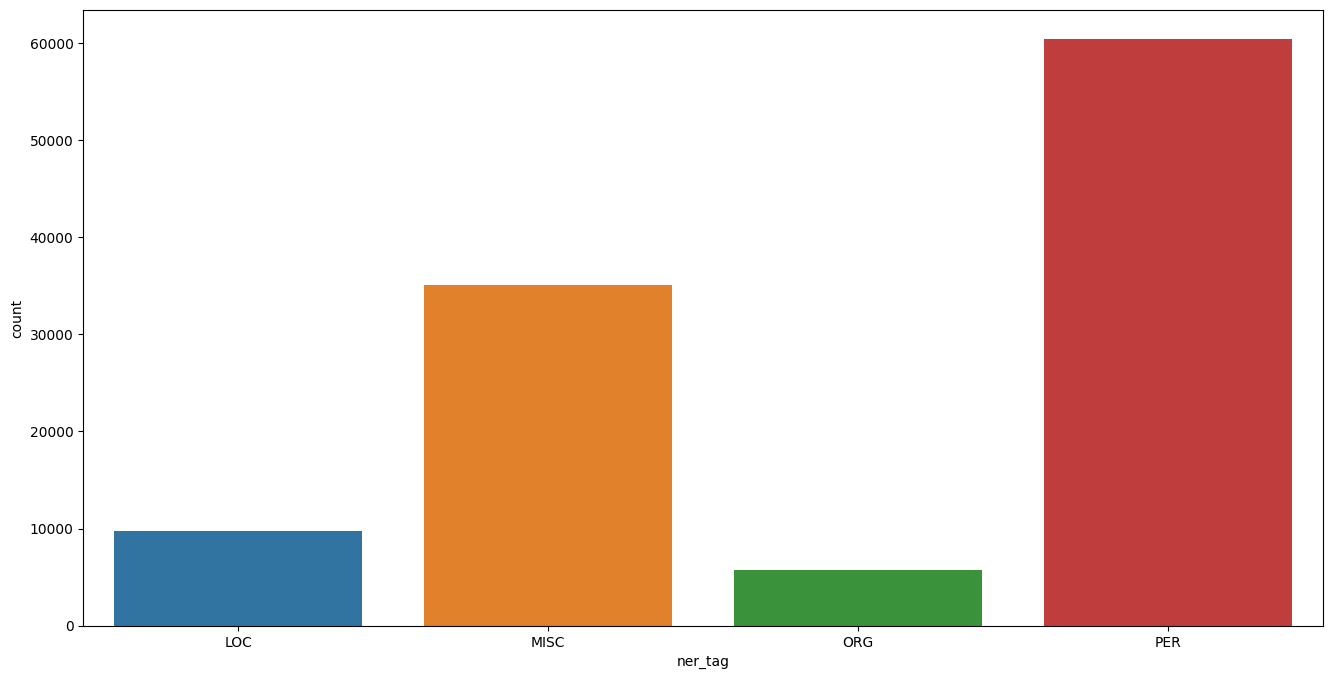

In [46]:
import seaborn as sns
data = [{'ner_tag': k, 'count': v} for (k, v) in counts_docs.items()]
df = pd.DataFrame(data)
df = df.sort_values(by=['ner_tag'])
sns.barplot(data=df[df['ner_tag'] != 'O'], x='ner_tag', y='count')

#### Analysis: Named Entities in questions

In [47]:
counts_questions = defaultdict(int)

for i in range(len(ner_tagged_question_dataset)):
  ner_tags = ner_tagged_question_dataset[i]['ner_tags_str']
  for j in range(len(ner_tags)):
    counts_questions[ner_tags[j]] += 1

<Axes: xlabel='ner_tag', ylabel='count'>

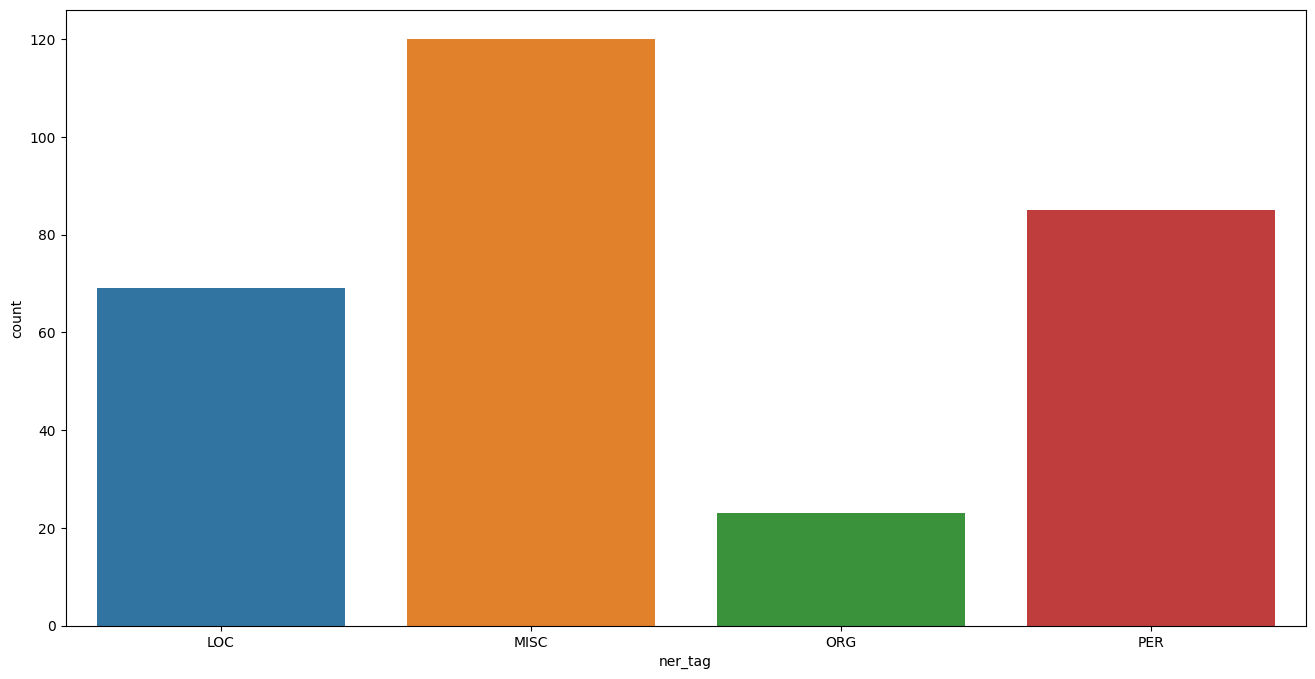

In [48]:
data = [{'ner_tag': k, 'count': v} for (k, v) in counts_questions.items()]
df = pd.DataFrame(data)
df = df.sort_values(by=['ner_tag'])
sns.barplot(data=df[df['ner_tag'] != 'O'], x='ner_tag', y='count')

In [49]:
for i in range(len(ner_tagged_jeopardy_dataset)):
  assert len(ner_tagged_jeopardy_dataset[i]['tokens']) == len(ner_tagged_jeopardy_dataset[i]['ner_tags_str'])

In [88]:
import math
import copy
import numpy as np

def Entity_TFIDF(query_tokens, query_ner_tags, document_tokens, document_ner_tags, jeopardy_data, query_idft):
  # Tokenize the query and document into individual terms
  #query_tokens = question.split()
  #document_tokens = document #.split() - already tokenized

  #print("Query tokens: {}\n".format(query_tokens))
  #print("Document tokens: {}\n".format(document_tokens))
  #print("Document NER tags: {}\n".format(document_ner_tags))

  #print(len(document_tokens), len(document_ner_tags))
  assert len(document_tokens) == len(document_ner_tags)

  # Log-weight the term frequency of each term in the query and document
  query_tf_raw = {}
  #print(len(query_tokens), len(document_tokens))
  for t in range(len(document_tokens)):
    for v in range(len(query_tokens)):
      '''
      if (document_tokens[t] == query_tokens[v]):
        if ((document_ner_tags[t] == query_ner_tags[v]) and document_ner_tags[t] != 'O'):
          print("match {} from document with {} from query\n".format(document_tokens[t], query_tokens[v]))
      '''
      
      if (document_tokens[t] == query_tokens[v]) and (document_ner_tags[t] == query_ner_tags[v]):
        if document_tokens[t] not in query_tf_raw:
          query_tf_raw[document_tokens[t]] = 0
        else:
          query_tf_raw[document_tokens[t]] += 1

    '''
    if document_tokens[t] not in query_tf_raw:
      query_tf_raw[document_tokens[v]] = 0
    '''
  #print("Query tf raw weights: {}\n".format(query_tf_raw))

  query_tf = {}

  for term in query_tf_raw:
    if query_tf_raw[term] == 0:
      query_tf[term] = 0
    else:
      query_tf[term] = 1+math.log10(query_tf_raw[term])


  # for each term in a document, if that term also appears in query, compute its TFIDF and
  # store it in a dictionary.

  # iterate over that dictionaries keys and values, putting all values in a vector,

  # convert that vector to numpy array, cosine normalize it and take its sum to obtain final TFIDF ranking
  TFIDF = {}
  for term in document_tokens:
    if term in query_tokens:
      if term not in query_tf or term not in query_idft:
        TFIDF[term] = 0
      else:
        TFIDF[term] = query_tf[term] * query_idft[term]
  
  scores = []
  for term in TFIDF:
    scores.append(TFIDF[term])
  
  scores_vector = np.array(scores)
  #print("Query tf weights: {}\n".format(query_tf))
  scores_length = math.sqrt(sum([score ** 2 for score in scores_vector]))
  scores_vector_normalized = [score / scores_length if scores_length != 0 else 0 for score in scores_vector]
  ranking_score = np.sum(scores_vector_normalized)

  #print("For this document, score: {}\n".format(ranking_score))
  return ranking_score

  '''
  # jeopardy data is for dft and idft calculation
  doc_freq = {}
  for a in range(len(query_tokens)):
    for b in range(len(jeopardy_data)):
      tokens_b = jeopardy_data[b]['tokens']
      ner_tags_str_b = jeopardy_data[b]['ner_tags_str']
      # threshold for NE's found in doc having same NE type as query
      thresh = 5
      counter = 0
      for c in range(len(tokens_b)):
        if (query_tokens[a] == tokens_b[c]) and (query_ner_tags[a] == ner_tags_str_b[c]):
          counter += 1 # early stopping if counter equals thresh
          if query_tokens[a] not in doc_freq:
            doc_freq[query_tokens[a]] = 0
          else:
            doc_freq[query_tokens[a]] += 1
        # optimization: if within this doc I find thresh queries having same entity type and lexical match as query, I stop
        if counter == thresh:
          break 
  '''
  #N = len(jeopardy_data)

  #print("Query dft: {}\n".format(doc_freq))
  '''

  query_tf = {query_tokens[t]: 1+math.log10(query_tokens.count(query_tokens[t])))}
  # Set the Log-weight of each term in document that doesn't appear in query to be 0
  for t in range(len(document_tokens)):
    if document_tokens[t] not in query_tokens:
      query_tf[document_tokens[t]] = 0

  #print("Query tf weights: {}\n".format(query_tf))

  document_tf = {document_tokens[t]: 1+math.log10(document_tokens.count(document_tokens[t])) for t in range(len(document_tokens)}
  # Set the Log-weight of each term in query that doesn't appear in document to be 0
  for t in range(len(query_tokens)):
    if query_token[t] not in document_tokens:
      document_tf[query_token[t]] = 0

  #print("Document tf weights: {}\n".format(document_tf))

  assert len(query_tf.keys()) == len(document_tf.keys())
  # Statistics to compute IDF weight of each term in the query
  N = len(jeopardy_data)

  # counts in how many documents each query term appears
  query_df = {}
  for j in range(len(jeopardy_data)):
    page_title = jeopardy_data[i]['title'].split(' ')
    page_tokens = jeopardy_data[i]['tokens']
    # check if query term appears in the title OR tokens - increment its df by 1 only in either case
    for term in query_tf:
      if term in page_title or term in page_tokens:
        if term not in query_df:
          query_df[term] = 0
        else:
          query_df[term] += 1
      # if the term doesn't appear in any page title or page_token - still set its df to be 0
      if term not in query_df:
        query_df[term] = 0

  #print("Query DF: {}\n".format(query_df))

  #query_df = {'auto': 5000, 'best': 50000, 'car': 10000, 'insurance': 1000}

  #query_idf = {term: math.log10(N / (1 + document_tokens.count(term))) for term in query_tf}

  query_idf = {term: math.log10(N / (1 + query_df[term])) for term in query_df}
  #print("Query IDF weights: {}\n".format(query_idf))

  # Calculate the TF-IDF score for each term in the query and document
  query_tfidf = {term: query_tf[term] * query_idf[term] for term in query_tf}
  #print("Query TFIDF weights: {}\n".format(query_tfidf))

  query_vector = [query_tfidf[term] for term in query_tfidf]

  document_weights = copy.deepcopy(document_tf)

  #print("Document weights: {}\n".format(document_weights))

  document_vector = [document_weights[term] for term in query_tfidf]

  #print("Query vector: {}\n".format(query_vector))
  #print("Document vector: {}\n".format(document_vector))

  # Perform cosine length normalization for the document
  document_length = math.sqrt(sum([score ** 2 for score in document_vector]))
  document_normalized = [score / document_length if document_length != 0 else 0 for score in document_vector]

  #print("document norm: {}\n".format(document_length))

  #print("document normalized scores: {}\n".format(document_normalized))

  sim_score = np.dot(np.array(query_vector), np.array(document_normalized))

  #print("similarity score of document with query: {}\n".format(sim_score))

  return sim_score # similarity b/w single question and document
  '''

In [91]:
sum_reciprocal_ranks = 0
for i in range(1, len(ner_tagged_question_dataset)+1):
  question_tokens = ner_tagged_question_dataset[i-1]['tokens']
  question_ner_tags = ner_tagged_question_dataset[i-1]['ner_tags_str']

  # retrieve titles and page content of top-20 candidate's for each question
  #print(questions_lemmatized[i])

  # Set the question number
  question_number = "Q"+str(i)

  # Construct the file path
  file_path = os.path.join("questions", question_number, f"{question_number}_candidate_answers")

  # Open the file and read the lines into a list
  with open(file_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

  # Print the list of lines - which are candidate titles for that doc
  local_candidates = [] # list of tuples with title/answer and TFIDF score
  jeopardy_data_subset = []
  for cand_title in lines:
    # retrieve docs from jeopardy data
    for j in range(len(jeopardy_data)):
      if jeopardy_data[j]["title"] == cand_title:
        # if we only want to search in the top-20 candidates for each question
        #jeopardy_data_subset.append(jeopardy_data[j])
        jeopardy_data_subset.append(ner_tagged_jeopardy_dataset[j])
    
  # operate over jeopardy data subset only - retrieve docs only from the subset
  '''
  for cand_doc in jeopardy_data_subset:
    # call TFIDF here
    cand_doc_score = TFIDF(questions_lemmatized[i], cand_doc['tokens'], jeopardy_data_subset)
    local_candidates.append((cand_doc['title'], cand_doc_score))
  '''

  # since I already know the question tokens, I can calculate dft and idft here outside of main loop
  # jeopardy data is for dft and idft calculation
  doc_freq = {}
  for a in range(len(question_tokens)):
    for b in range(len(ner_tagged_jeopardy_dataset)):
      tokens_b = ner_tagged_jeopardy_dataset[b]['tokens']
      ner_tags_str_b = ner_tagged_jeopardy_dataset[b]['ner_tags_str']
      # threshold for the same query term being found in doc but having thresh number of different entity types
      #thresh = 5
      #counter = 0
      for c in range(len(tokens_b)):
        if (question_tokens[a] == tokens_b[c]) and (question_ner_tags[a] == ner_tags_str_b[c]):
          #counter += 1 # early stopping if counter equals thresh
          if question_tokens[a] not in doc_freq:
            doc_freq[question_tokens[a]] = 0
          else:
            doc_freq[question_tokens[a]] += 1
          break
        
        # optimization: if within this doc I find thresh number of the same lexical query term having different entity 
        # type I stop
        #if counter == thresh:
        #  break 
  
  N = len(jeopardy_data)

  print("Query dft: {}\n".format(doc_freq))

  query_idft = {}

  for term in doc_freq:
    query_idft[term] = math.log10(N/(doc_freq[term]+1))

  print("Query idft: {}\n".format(query_idft))

  # operate over full jeopardy dataset
  for k in range(len(ner_tagged_jeopardy_dataset)):
    # call TFIDF here
    cand_doc_score = Entity_TFIDF(question_tokens, question_ner_tags, ner_tagged_jeopardy_dataset[k]['tokens'], ner_tagged_jeopardy_dataset[k]['ner_tags_str'], ner_tagged_jeopardy_dataset,
                           query_idft)
    local_candidates.append((jeopardy_data[k]['title'], cand_doc_score))

  local_candidates_ranked = sorted(local_candidates, key=lambda x: x[1], reverse=True)
  print(local_candidates_ranked)
  # MRR score calculation for Entity_TFIDF
  rank = 0
  for j in range(len(local_candidates_ranked)):
    if local_candidates_ranked[j][0] in q_to_ans[questions_lemmatized[i-1]]:
      rank = j+1
      break
  # Calculate the reciprocal rank
  if rank != 0:
    reciprocal_rank = 1.0 / rank
  else:
    reciprocal_rank = 0.0
  
  sum_reciprocal_ranks += reciprocal_rank
  # just check one for now
  #break

MRR = sum_reciprocal_ranks/len(questions_lemmatized)
print("MRR for EntityTFIDF: {}\n".format(MRR))


Output hidden; open in https://colab.research.google.com to view.